In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

# import warnings
# warnings.simplefilter('ignore')

In [2]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (8,5)

## Helper Functions

In [4]:
def residual_plot(y_pred, y_train):
    res = y_train - y_pred
    plt.scatter(y_pred, res, s=3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    return plt.show();

In [38]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(12,5))
    
#     s = x.shape[0]
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

1.5485322279886016


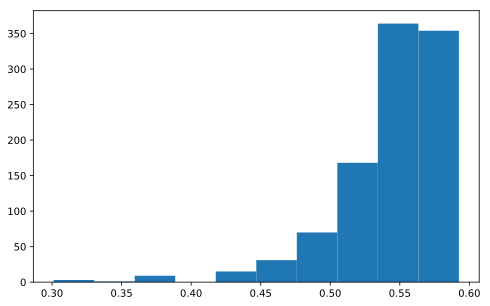

In [45]:
from scipy import stats

lamb=stats.boxcox_normmax(df_model.rating, brack=(-2.0, 2.0))
print(lamb)
y_t=(np.power(df_model.rating,-1.548)-1)/-1.548

plt.hist(y_t);

### Preprocessing

In [6]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df, minvotes=4)

In [7]:
# Create 

# df = df[df.countreports > 0]
# df['log_countreports'] = np.log(df['countreports'])
# df['log_votes'] = np.log(df['votes'])

In [8]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype


#cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']

# use below if doing log of countreports and votes
# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint', 'log_countreports', 'log_votes']


cont_feats = ['countreports', 'length', 'gain', 'hpoint']


# cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']

oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])
#print(oh_cols)
# combine with the one hot encoding variables

# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
# X = np.concatenate([oh_cols, fees_processed, region_processed], axis=1) ## Remove continuous features
# X = np.concatenate([XS], axis=1) ## Only continuous features

y = df['rating'] # SEE BELOW - I NOW MADE y and X OFF A PANDAS DATAFRAME

# This code makes a DF of my transformed variables. There is some weird stuff in there with neg lengths...
y2 = y[:,np.newaxis]
XSpecial = np.concatenate([X, y2], axis=1)
df_model = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['rating']))

y = df_model['rating']
X = df_model.drop('rating',axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Tips from Chad on what I can do now:
* Plot whatever feats I want to explore vs residuals
* Look for patterns in data
* If I am missing data in a certain area of my predicted vs actual plots, then take subset and look there
* plot sum /log / function of the categorical features, vs residuals.

##### Once I find a pattern and want to Feat Eng., then add a new column to my X data array.

In [9]:
# Who is our audience for Project 2? Recruiters? classmates?
### How do you recommend showing model? Need coefficients. Just "say" how well it did on a few?

### Should I graph out MSE test vs train to help me decide on polynomial degrees? I already know 2 is better
### than 3 or 1

# Graphs probably look good in presentation.

# Test Train Split

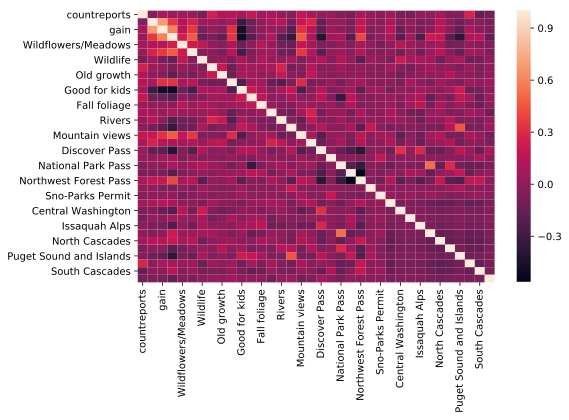

In [10]:
sns.heatmap(X.corr());

In [11]:
#pprint.pprint(coefs)

In [12]:
# # New training based on excluding variables that a LassoCV zeroed out
# X_lassoed = X.drop(columns=['length','gain','hpoint','Dogs allowed on leash', 'Established campsites', 'National Monument Fee',
#       'None','Refuge Entrance Pass', 'Central Washington','Eastern Washington', 'North Cascades',
#       'Snoqualmie Region', 'Southwest Washington'])

# # second Lasso to weed out more

# X_again = X_lassoed.drop(columns=['Central Cascades', 'Northwest Forest Pass','Rivers'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
## Reduced features due to lasso
# X_train, X_test, y_train, y_test = train_test_split(X_lassoed, y)

In [15]:
## Reduced features FOR THE 2ND TIME due to lasso
# X_train, X_test, y_train, y_test = train_test_split(X_again, y)

### Test Suite

In [31]:
alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]

lr = LinearRegression()
lr.fit(X_train, y_train)
print("LinReg - Poly 1")
print("Train R^2:", lr.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("")

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
# cross_validate(poly_lr, X_train, y=y_train)
poly_lr.fit(X_train, y_train)
print("LinReg - Poly 2")
print("Train R^2:", poly_lr.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("")

lasso = LassoCV(cv=5, alphas=alphas)
lasso.fit(X_train, y_train)
print("LassoCV - Poly 1")
print("Train R^2:", lasso.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("")

# poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV(cv=5, alphas=alphas))
# poly_lasso.fit(X_train, y_train)
# print("LassoCV - Poly 2")
# print("Train R^2:", poly_lasso.score(X_train, y_train))
# print("")

# print("")

# ##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
# print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
# print('Test R^2: ', poly_lasso.score(X_test, y_test))
# print("alpha used:", poly_lasso.get_params()['lassocv'].alpha_)


ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("RR - Poly 1")
print("Train R^2:", ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("")

poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5, alphas=alphas))
poly_ridge.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)


LinReg - Poly 1
Train R^2: 0.2462174476260253
Train MSE: 0.331472788780231

LinReg - Poly 2
Train R^2: 0.6820378347531477
Train MSE: 0.13982255931639645

LassoCV - Poly 1
Train R^2: 0.20964020283009854
Train MSE: 0.3475574823038717



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

RR - Poly 1
Train R^2: 0.2422897975618178
Train MSE: 0.33319995680240855



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.024846e-17
  overwrite_a=False)
/home/spe

RR - Poly 2
Train R^2: 0.38054727129278365
Train MSE: 0.27240179923962143

Test RMSE: 0.6225580342885623
Test MSE: 0.3875785060572387
Test R^2:  0.1824825580431868

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Linear Regression

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("intercept:",lr.intercept_)
# print("coefficients,",lr.coef_)

y_pred_tr = lr.predict(X_train)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_tr)))
print("Train MSE:", metrics.mean_squared_error(y_train, y_pred_tr))
print("Train R^2:", lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))z

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lr.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.6234567768964054
Train RMSE: 0.5757367356528772
Train MSE: 0.331472788780231
Train R^2: 0.2462174476260253




In [18]:
"""Polynomial with LinearRegression"""

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)

y_pred_tr = poly_lr.predict(X_train)


print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")


y_pred_test = poly_lr.predict(X_test)

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print('Test R^2: ', poly_lr.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lr.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.37392854841051715
Train MSE: 0.13982255931639645
Train R^2: 0.6820378347531477

Test RMSE: 1.1262849632133103
Test MSE: 1.2685178183604076
Test R^2:  -1.6756784128516289



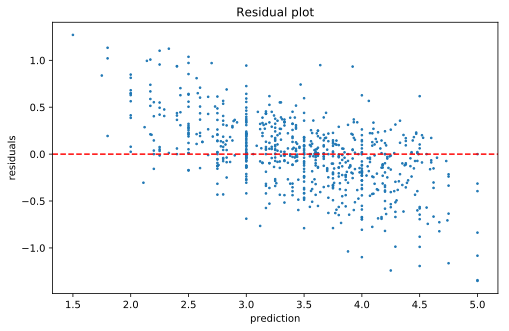

In [19]:
# plot of poly_lr
residual_plot(y_train, poly_lr.predict(X_train))

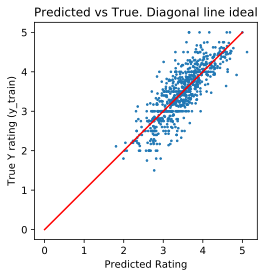

In [20]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lr.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.title("Predicted vs True. Diagonal line ideal")
plt.plot(range(6), c='r');

# Lasso

In [21]:
#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("intercept:",lasso.intercept_)
# print("coefficients,",lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("Train R^2:", lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lasso.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.3038538152224715
Train RMSE: 0.5825447209151583
Train MSE: 0.3393583518661196
Train R^2: 0.22828535765972624




In [22]:
"""Polynomial with LassoCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_lasso = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(cv=3, alphas=alphas))
poly_lasso.fit(X_train, y_train)
#print("intercept:",poly_lasso.intercept_)
# print("coefficients,",poly_lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))

print("")

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Train RMSE: 0.5700290442793735
Train MSE: 0.324933111322056
Train R^2: 0.26108893914201214

Test RMSE: 0.6159150738776935
Test MSE: 0.3793513782297646
Test R^2:  0.19983599841992183



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [23]:
# simple_lasso= LassoCV(cv=3)
# simple_lasso.fit(X_train, y_train)

In [24]:
# coefs_list = X_lassoed.columns
# # newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# # newlist = cont_feats ## only continuous features
# import pprint
# coefs = sorted(zip(coefs_list, np.round(simple_lasso.coef_,3)), key=lambda x: x[1], reverse=True)
# pprint.pprint(coefs)

In [25]:
# coefs

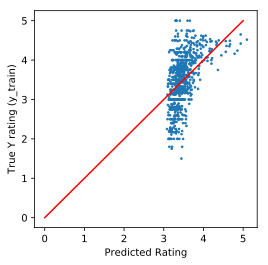

In [26]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lasso.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

# Ridge Regression

In [27]:
#Straight Ridge Regression

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("intercept:",ridge.intercept_)
# print("coefficients,",ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("Train R^2:", ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(ridge.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.314050557159015
Train RMSE: 0.5772347501687753
Train MSE: 0.33319995680240855
Train R^2: 0.2422897975618178




In [28]:
"""Polynomial with RidgeCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_ridge = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(cv=3, alphas=alphas))
poly_ridge.fit(X_train, y_train)
#print("intercept:",poly_ridge.intercept_)
# print("coefficients,",poly_ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_ridge.coef_,3)), key=lambda x: x[1], reverse=True))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.365704e-17
  overwrite_a=False)
/home/spe

Train RMSE: 0.530412836873959
Train MSE: 0.281337777520681
Train R^2: 0.36022649461171075

Test RMSE: 0.6270249077933612
Test MSE: 0.3931602349932731
Test R^2:  0.17070904457386837

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


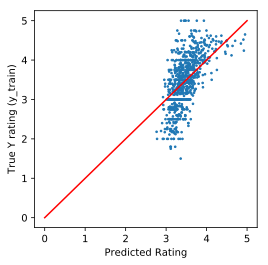

In [29]:
plt.figure(figsize=(4,4))
plt.scatter(poly_ridge.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

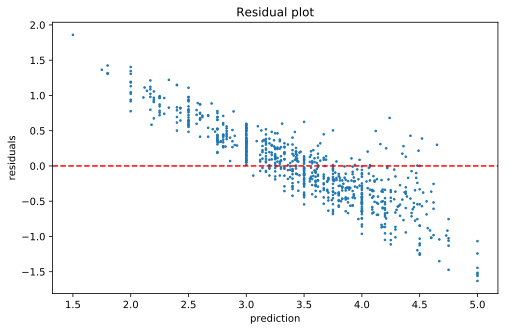

In [30]:
residual_plot(y_train, poly_ridge.predict(X_train))

# Feature Engineering and EDA

# Plots

In [ ]:
# try rating = log(votes), log(countreports)

In [ ]:
sns.pairplot(df_model, y_vars = 'rating', x_vars = df_special.columns[:-1]);

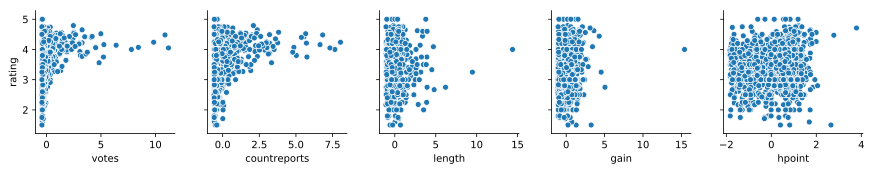

In [31]:
sns.pairplot(df_model, y_vars = 'rating', x_vars = cont_feats);

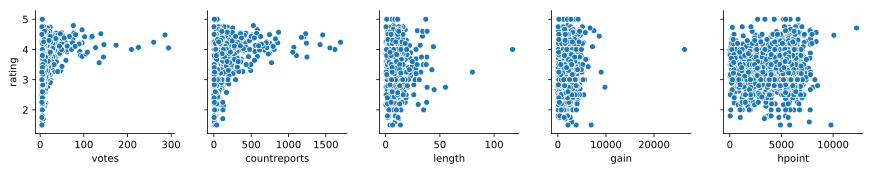

In [29]:
sns.pairplot(df, y_vars = 'rating', x_vars= cont_feats);

In [ ]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

In [ ]:
# sns.pairplot(df[(df.votes > 3) & (df.length < 60) & (df.hpoint < 9000)],
#              x_vars=['votes','length','gain','hpoint','countreports'],
#              y_vars='rating')

In [ ]:
# # votes and count reports are highly correlated
# plt.scatter(df['votes'], df['countreports']);